# 零基础实战机器学习 源代码

## 第14讲 用Lifelines工具包做留存分析

作者 黄佳

极客时间专栏链接：https://time.geekbang.org/column/intro/438

在这一讲中，我们主要分析用户留存和流失的相关因素，并进行预测。
我们使用Lifelines工具包完成这个任务。

### 安装并导入工具包

In [1]:
# pip install lifelines

In [2]:
# 导入数据包
import numpy as np #导入NumPy
import pandas as pd #导入Pandas
df_member = pd.read_csv('易速鲜花会员留存.csv') #载入数据集
df_member.head() #显示数据头几行

,用户码,性别,玫瑰套餐,紫罗兰套餐,郁金香套餐,百合套餐,康乃馨套餐,胡姬花套餐,生日套餐,情人节套餐,会员卡类型,入会月数,会费支付方式,平均月消费,总消费,已停付会费
0,1,女,是,是,否,是,否,是,是,否,年卡,9,手工转账,65.6,593.3,否
1,2,男,否,否,否,否,否,否,否,是,月卡,9,手工转账,59.9,542.4,否
2,3,男,否,否,否,否,是,否,否,否,月卡,4,就餐时付费,73.9,280.85,是
3,4,男,是,否,否,是,是,否,是,是,月卡,13,就餐时付费,98.0,1237.85,是
4,5,女,否,是,否,否,否,是,是,是,月卡,9,花呗付款,69.4,571.45,否


In [3]:
df_member.describe()

,用户码,入会月数,平均月消费
count,7043.000000,7043.000000,7043.000000
mean,3522.000000,32.371149,64.761692
std,2033.283305,24.559481,30.090047
min,1.000000,0.000000,18.250000
25%,1761.500000,9.000000,35.500000
50%,3522.000000,29.000000,70.350000
75%,5282.500000,55.000000,89.850000
max,7043.000000,72.000000,118.750000


### 数据清洗

In [4]:
from pandas.api.types import is_numeric_dtype #导入is_numeric_dtype工具
is_numeric_dtype(df_member['总消费']) #是否为数值字段？

False

In [5]:
df_member['总消费'] = pd.to_numeric(df_member['总消费'], errors='coerce') #把总消费字段转换成数值字段
df_member['总消费'].fillna(0, inplace=True) #补充0值

In [6]:
from pandas.api.types import is_numeric_dtype
is_numeric_dtype(df_member['平均月消费'])

True

In [7]:
#把总消费字段转换成数值字段
df_member['总消费'] = pd.to_numeric(df_member['总消费'], errors='coerce')
df_member['总消费'].fillna(0, inplace=True)

In [8]:
from pandas.api.types import is_numeric_dtype
is_numeric_dtype(df_member['总消费'])

True

### 数据可视化

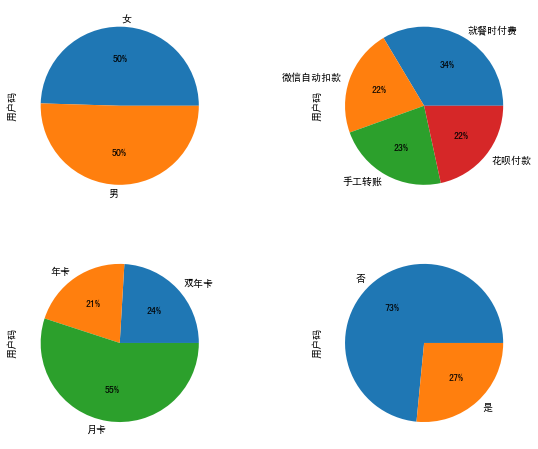

In [9]:
import matplotlib.pyplot as plt #导入绘图工具
plt.figure(figsize=(10,8)) #图片大小
plt.subplot(2, 2, 1) #子图1
ax = df_member.groupby('性别').count()['用户码'].plot.pie(autopct='%1.0f%%') #饼图1
plt.subplot(2, 2, 2) #子图2
ax = df_member.groupby('会费支付方式').count()['用户码'].plot.pie(autopct='%1.0f%%') #饼图2
plt.subplot(2, 2, 3) #子图3
ax = df_member.groupby('会员卡类型').count()['用户码'].plot.pie(autopct='%1.0f%%') #饼图3
plt.subplot(2, 2, 4) #子图4
ax = df_member.groupby('已停付会费').count()['用户码'].plot.pie(autopct='%1.0f%%') #饼图4
plt.show() #显示

### 特征工程

In [10]:
# 把汉字转换成0、1值
df_member['已停付会费'].replace(to_replace='是', value=1, inplace=True)
df_member['已停付会费'].replace(to_replace='否',  value=0, inplace=True)
df_member['性别'].replace(to_replace='女', value=0, inplace=True)
df_member['性别'].replace(to_replace='男', value=1, inplace=True)

In [11]:
# 其它的是、否字段转换成布尔型数据
binary_features = ['玫瑰套餐', '紫罗兰套餐', '郁金香套餐', 
                   '百合套餐', '康乃馨套餐', '胡姬花套餐', 
                   '生日套餐','情人节套餐']
for field in binary_features:
    df_member[field] = df_member[field] == '是'

In [12]:
df_member # 显示数据

,用户码,性别,玫瑰套餐,紫罗兰套餐,郁金香套餐,百合套餐,康乃馨套餐,胡姬花套餐,生日套餐,情人节套餐,会员卡类型,入会月数,会费支付方式,平均月消费,总消费,已停付会费
0,1,0,True,True,False,True,False,True,True,False,年卡,9,手工转账,65.60,593.30,0
1,2,1,False,False,False,False,False,False,False,True,月卡,9,手工转账,59.90,542.40,0
2,3,1,False,False,False,False,True,False,False,False,月卡,4,就餐时付费,73.90,280.85,1
3,4,1,True,False,False,True,True,False,True,True,月卡,13,就餐时付费,98.00,1237.85,1
4,5,0,False,True,False,False,False,True,True,True,月卡,9,花呗付款,69.40,571.45,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7039,0,False,False,True,False,False,True,False,False,年卡,13,手工转账,55.15,742.90,0
7039,7040,1,False,False,False,True,False,False,False,False,月卡,2,手工转账,50.30,92.75,0
7040,7041,1,True,False,False,False,False,False,False,True,月卡,22,就餐时付费,85.10,1873.70,1
7041,7042,1,True,True,True,False,True,True,False,True,双年卡,67,手工转账,67.85,4627.65,0


## 绘制生存曲线

我们使用Kaplan-Meier生存曲线来查看普通客户的生存率。
使用下面的代码，我们可以将KM生存曲线拟合到客户流失数据，并以置信区间绘制我们的生存曲线。
生存曲线是累积的。 意思是，在下图中，在20个月后，客户不取消服务的机会刚好超过80％。

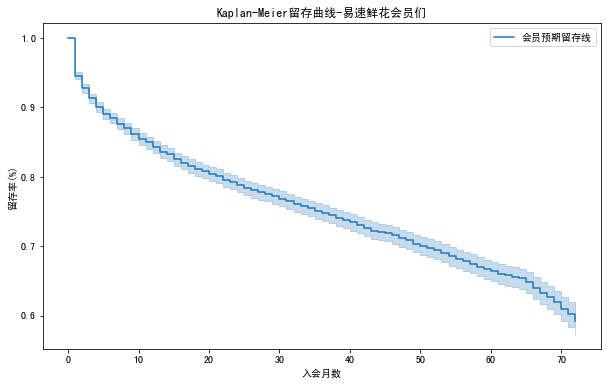

In [13]:
import lifelines #导入生存分析工具包
kmf = lifelines.KaplanMeierFitter() #创建KMF模型
kmf.fit(df_member['入会月数'], #拟合易速鲜花会员流失数据
        event_observed=df_member['已停付会费'], 
        label='会员预期留存线')
fig, ax = plt.subplots(figsize=(10,6)) #画布
kmf.plot(ax=ax) #绘图
ax.set_title('Kaplan-Meier留存曲线-易速鲜花会员们') #图题
ax.set_xlabel('入会月数') #X轴标签
ax.set_ylabel('留存率(%)') #Y轴标签
plt.show() #显示图片

### 按照不同的类别比较生存曲线

In [14]:
def life_by_cat(feature, t='入会月数', event='已停付会费', df=df_member, ax=None): #定义分类留存曲线函数
    for cat in df[feature].unique(): #遍历类别
        idx = df[feature] == cat #当前类别
        kmf = lifelines.KaplanMeierFitter() #创建KaplanMeier模型
        kmf.fit(df[idx][t], event_observed=df[idx][event], label=cat) #拟合模型
        kmf.plot(ax=ax, label=cat) #绘图

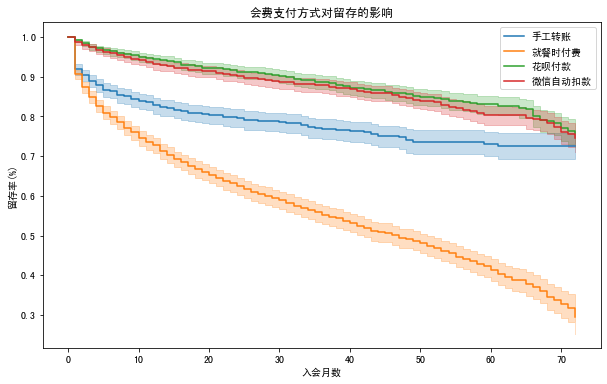

In [15]:
fig_pmt, ax_pmt = plt.subplots(figsize=(10,6)) #画布
life_by_cat(feature='会费支付方式', ax=ax_pmt) #调用函数
ax_pmt.set_title('会费支付方式对留存的影响') #图题
ax_pmt.set_xlabel('入会月数') #X轴标签
ax_pmt.set_ylabel('留存率(%)') #Y轴标签
plt.show() #显示图片

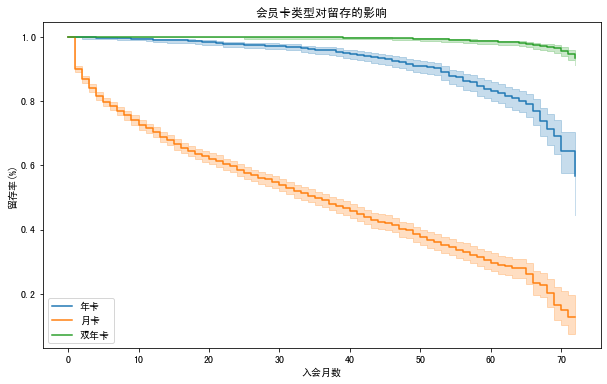

In [16]:
fig_contract, ax_contract = plt.subplots(figsize=(10,6)) #画布
life_by_cat(feature='会员卡类型', ax=ax_contract) #调用函数
ax_contract.set_title('会员卡类型对留存的影响') #图题
ax_contract.set_xlabel('入会月数') #X轴标签
ax_contract.set_ylabel('留存率(%)') #Y轴标签
plt.show() #显示图片

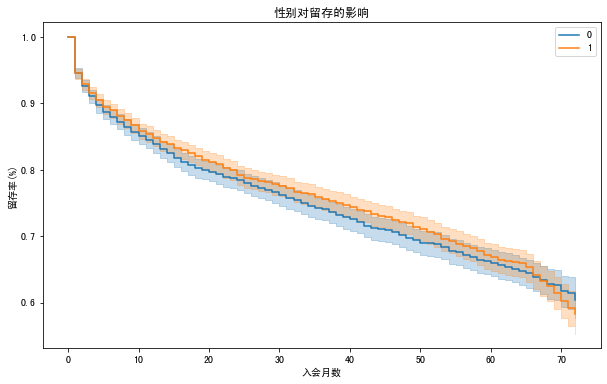

In [17]:
fig_gender, ax_gender = plt.subplots(figsize=(10,6)) #画布
life_by_cat(feature='性别', ax=ax_gender) #调用函数
ax_gender.set_title('性别对留存的影响') #图题
ax_gender.set_xlabel('入会月数') #X轴标签
ax_gender.set_ylabel('留存率(%)') #Y轴标签
plt.show() #显示图片

## Cox比例危害模型

为了检查不同功能的影响，我们将使用Cox比例危害模型。 
我们可以将其视为生存回归模型。可以认为“危险”会增加/减少生存机会。 
例如，在我们的业务问题中，危害可能是客户拥有的合同类型。具有多年合同的客户取消合同的频率可能比具有月度合同的客户取消合同的频率低。
一个限制是模型假设各组之间的危害随时间变化的比率是恒定的。 Lifeline为CoxPHFitter对象提供了一个内置的check_assumptions方法。
经过一些数据清理，包括编码分类变量（k-1虚拟变量），我们可以将生存回归模型拟合到数据中。

### 数据整理
先做数据整理工作，把每个数据字段都转换为可以处理的字段

In [18]:
#把分类字段转换为哑编码
category_features = ['会员卡类型', '会费支付方式'] #要转换的分类的字段
df_member = pd.get_dummies(df_member, #哑变量的个数会比总类别数少1 
                           drop_first=True, #这是因为drop_first=True
                           columns=category_features) #这能够避免回归中的多重共线性问题 
df_member #显示数据

,用户码,性别,玫瑰套餐,紫罗兰套餐,郁金香套餐,百合套餐,康乃馨套餐,胡姬花套餐,生日套餐,情人节套餐,入会月数,平均月消费,总消费,已停付会费,会员卡类型_年卡,会员卡类型_月卡,会费支付方式_微信自动扣款,会费支付方式_手工转账,会费支付方式_花呗付款
0,1,0,True,True,False,True,False,True,True,False,9,65.60,593.30,0,1,0,0,1,0
1,2,1,False,False,False,False,False,False,False,True,9,59.90,542.40,0,0,1,0,1,0
2,3,1,False,False,False,False,True,False,False,False,4,73.90,280.85,1,0,1,0,0,0
3,4,1,True,False,False,True,True,False,True,True,13,98.00,1237.85,1,0,1,0,0,0
4,5,0,False,True,False,False,False,True,True,True,9,69.40,571.45,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7039,0,False,False,True,False,False,True,False,False,13,55.15,742.90,0,1,0,0,1,0
7039,7040,1,False,False,False,True,False,False,False,False,2,50.30,92.75,0,0,1,0,1,0
7040,7041,1,True,False,False,False,False,False,False,True,22,85.10,1873.70,1,0,1,0,0,0
7041,7042,1,True,True,True,False,True,True,False,True,67,67.85,4627.65,0,0,0,0,1,0


### 创建并拟合模型

In [19]:
cph = lifelines.CoxPHFitter() #创建模型
cph.fit(df_member, duration_col='入会月数', #拟合模型
        event_col='已停付会费', show_progress=False)

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>

### 绘制会员的生存曲线

<AxesSubplot:>

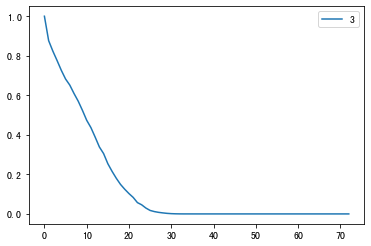

In [20]:
# 生存曲线绘制
cph.predict_survival_function(df_member.loc[3]).plot()

### 分析影响留存的因子

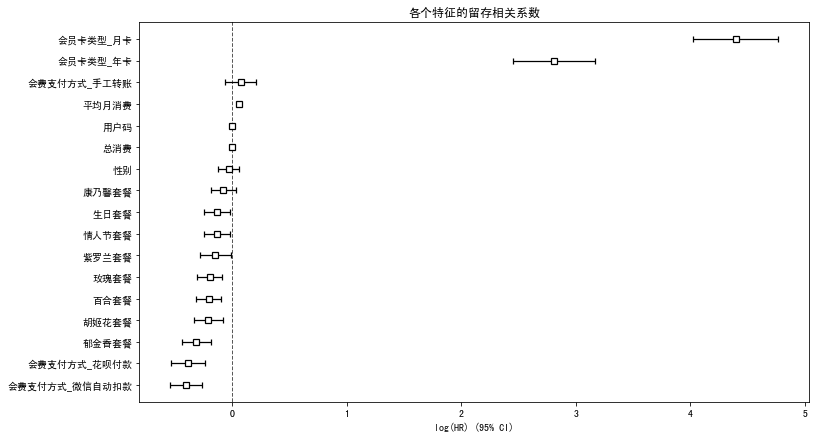

In [21]:
fig, ax = plt.subplots(figsize=(12,7)) #画布
ax.set_title('各个特征的留存相关系数') #图题
cph.plot(ax=ax) #绘图